In [1]:
import torch
import os
import torch
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#可选择将模型转移到GPU上进行训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Create Dataset

In [3]:
data_dir = './Dataset'

classes = os.listdir(data_dir)
print(classes)

['Trash', 'Recycle']


## Create transforms

In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), 
                                      transforms.ToTensor()]) # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
dataset = ImageFolder(data_dir, transform=transformations)

## Visualization Dataset

Label: Recycle (Class No: 0)


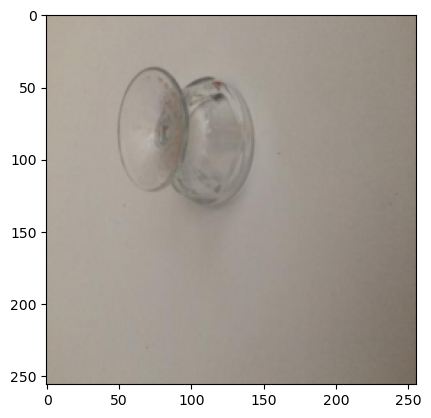

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print(f"Label: {dataset.classes[label]} (Class No: {str(label)})")
    plt.imshow(img.permute(1, 2, 0))

img, label = dataset[51]
show_sample(img, label)

### Create random seed

In [6]:
random_seed = 42
torch.manual_seed(random_seed)

### Split dataset

In [7]:
train_ds, val_ds = random_split(dataset, [210, 64])

test_dir = './Test_Dataset/'
test_ds = ImageFolder(test_dir, transform=transformations)

len(train_ds), len(val_ds), len(test_ds)

(210, 64, 2373)

### Create DataLoader

In [8]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

train_dl = DataLoader(dataset=train_ds,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

val_dl = DataLoader(val_ds,
                    batch_size*2, 
                    num_workers=4, 
                    pin_memory=True)

### Show DataLoader Images

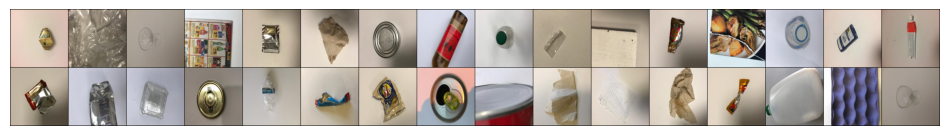

In [9]:
from torchvision.utils import make_grid

def show_batch(dl):
    for image, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.axis('off')
        ax.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

# Model Base

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss' : loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch: {epoch+1} train_loss: {result['train_loss']:.4f} val_loss: {result['val_loss']:.4f} val_acc: {result['val_acc']:.4f}")

In [11]:
class myMobileNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.mobilenet_v2(pretrained=True)
        self.network.classifier[1] = nn.Linear(in_features=1280, out_features=len(dataset.classes))
    
    def forward(self, x):
        return torch.sigmoid(self.network(x))

# 定义整个模型
model = myMobileNet()

/home/hal468a/anaconda3/envs/torch2.0/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hal468a/anaconda3/envs/torch2.0/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Training Model

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
model = model.to(device)
evaluate(model, val_dl)

{'val_loss': 0.7011590003967285, 'val_acc': 0.40625}

In [16]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch: 1 train_loss: 0.6615 val_loss: 0.6599 val_acc: 0.7812
Epoch: 2 train_loss: 0.5695 val_loss: 0.6028 val_acc: 0.8281
Epoch: 3 train_loss: 0.5068 val_loss: 0.5399 val_acc: 0.8750
Epoch: 4 train_loss: 0.4437 val_loss: 0.4955 val_acc: 0.8281
Epoch: 5 train_loss: 0.4027 val_loss: 0.4631 val_acc: 0.8906
Epoch: 6 train_loss: 0.3742 val_loss: 0.4419 val_acc: 0.9062
Epoch: 7 train_loss: 0.3637 val_loss: 0.4302 val_acc: 0.9062
Epoch: 8 train_loss: 0.3500 val_loss: 0.4178 val_acc: 0.9375
Epoch: 9 train_loss: 0.3299 val_loss: 0.4117 val_acc: 0.9375
Epoch: 10 train_loss: 0.3284 val_loss: 0.4072 val_acc: 0.9375
Epoch: 11 train_loss: 0.3233 val_loss: 0.4102 val_acc: 0.9062
Epoch: 12 train_loss: 0.3238 val_loss: 0.4089 val_acc: 0.9062
Epoch: 13 train_loss: 0.3201 val_loss: 0.4071 val_acc: 0.9219
Epoch: 14 train_loss: 0.3192 val_loss: 0.4055 val_acc: 0.9375
Epoch: 15 train_loss: 0.3218 val_loss: 0.4051 val_acc: 0.9219


### 儲存模型

In [17]:
# model_file = torch.save(model.state_dict(), f'./model/ModileNetV2.pth') # 僅儲存模型權重
# torch.save(model, f'./model/ModileNetV2_all.pth') # 儲存整個模型
model_dict = {
    'architecture': model,
    'state_dict': model.state_dict()
}

torch.save(model_dict, f'./model/ModileNetV2_all.pth') # 儲存整個模型

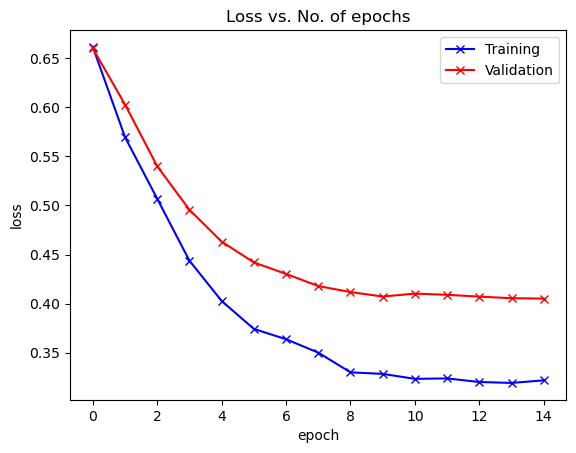

In [18]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

### Load Model to Predict

In [19]:
loaded_model_dict = torch.load('./model/ModileNetV2_all.pth')

loaded_model = loaded_model_dict['architecture']
state_dict = loaded_model_dict['state_dict']

loaded_model.load_state_dict(state_dict)

<All keys matched successfully>

In [20]:
def predict_image(img, model:nn.Module, device:torch.device):
    # Convert to a batch of 1
    model.to(device)
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: Recycle , Predicted: Recycle


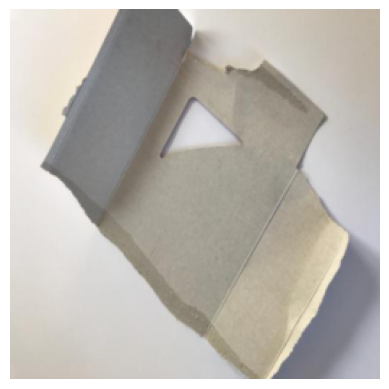

In [21]:
img, label = test_ds[453]
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, loaded_model, 'cpu'))

Label: Recycle , Predicted: Recycle


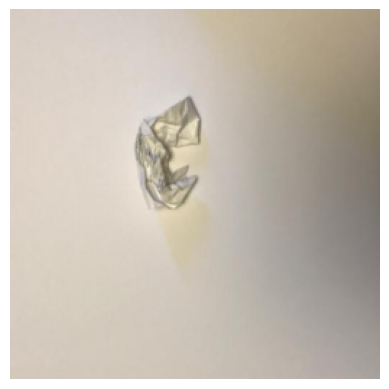

In [22]:
img, label = test_ds[77]
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, loaded_model, 'cpu'))

Label: Trash , Predicted: Trash


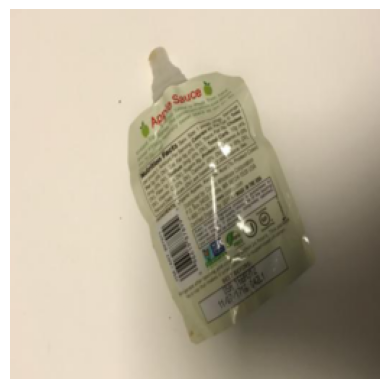

In [23]:
img, label = test_ds[2236]
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, loaded_model, 'cpu'))

Label: Recycle , Predicted: Trash


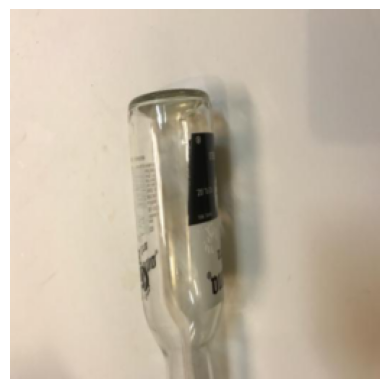

In [39]:
img, label = test_ds[347]
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, loaded_model, 'cpu'))